In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import make_multilabel_classification
import scipy.linalg
from sklearn.cross_decomposition import CCA
import rcca

In [2]:
def initialise_CCA(X,Y,m):
    # we will create the sample covariance matrix
    z = np.concatenate((X,Y)) #combine the tranposed data. 
    #Each row represents a variable and column represents sample
    # X & Y must have the same number of samples
    C = np.cov(z) 
        
    sx = X.shape[0] #find the dimensions of X and Y
    sy = Y.shape[0]
    n = X.shape[1]
        
    #we partition the covariance matrix into the respective elements
    Cxx = C[0:sx,0:sx]
    Cxy = C[0:sx,sx:sx+sy]
    Cyx = Cxy.T
    Cyy = C[sx:,sx:]
    
    u1,s1,v1 = np.linalg.svd(Cxx)
    s1_half_inv = np.dot(np.dot(u1,np.diag(1/np.sqrt(s1))),u1.T)
    u2,s2,v2 = np.linalg.svd(Cyy)
    s2_half_inv = np.dot(np.dot(u2,np.diag(1/np.sqrt(s2))),u2.T)
    sm = np.dot(np.dot(s1_half_inv,Cxy),s2_half_inv)
    u12,s12,v12 = np.linalg.svd(sm)

    W1_mu = np.dot(np.dot(np.dot(Cxx,s1_half_inv),u12[:,:m]),
                   np.diag(np.sqrt(s12[:m])))
    W2_mu = np.dot(np.dot(np.dot(Cyy,s2_half_inv),v12.T[:,:m]),
                   np.diag(np.sqrt(s12[:m])))
    
    EPhi1 = np.linalg.pinv(Cxx-np.dot(W1_mu,W1_mu.T))
    EPhi2 = np.linalg.pinv(Cyy-np.dot(W2_mu,W2_mu.T))
    mu1_mu = np.mean(X,axis = 1)
    mu2_mu = np.mean(Y,axis = 1)

    Mu1 = np.array([mu1_mu]*n).T
    Mu2 = np.array([mu2_mu]*n).T

    return W1_mu, W2_mu, EPhi1, EPhi2, Mu1, Mu2

In [177]:
X, Y = make_multilabel_classification(n_classes=2, n_labels=1,
                                      allow_unlabeled=True,
                                      random_state=1)

In [4]:
def plot_result(X,Y):
    zero_class = np.where(Y[:, 0])
    one_class = np.where(Y[:, 1])
    plt.scatter(X[:, 0], X[:, 1], s=40, c='gray')
    plt.scatter(X[zero_class, 0], X[zero_class, 1], s=160, edgecolors='b',
                   facecolors='none', linewidths=2, label='Class 1')
    plt.scatter(X[one_class, 0], X[one_class, 1], s=80, edgecolors='orange',
                   facecolors='none', linewidths=2, label='Class 2')

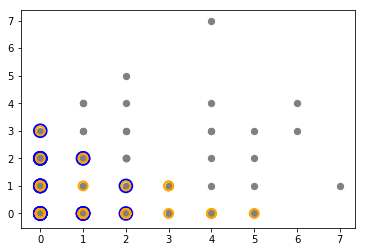

In [5]:
plot_result(X,Y)

In [6]:
def qr_CCA(X,Y,n_components):
    #perform qr decomposition for X and Y
    q1,r1 = np.linalg.qr(X)
    q2,r2 = np.linalg.qr(Y)
    #perform SVD of q1 and q2
    U,s,Vh = np.linalg.svd(np.dot(q1.T,q2))
    
    a = np.dot(np.linalg.pinv(r1),U[:,:n_components])
    b = np.dot(np.linalg.pinv(r2),Vh.T[:,:n_components])
    #return U[:,:n_components],s[:n_components],Vh.T[:,:n_components]
    return a,s[:n_components],b

In [7]:
def prob_CCA(X,Y,n_components = 2):
    # we will create the sample covariance matrix
    z = np.concatenate((X.T,Y.T)) #combine the tranposed data.
    
    #Each row represents a variable and column represents sample
    # X & Y must have the same number of samples
    C = np.cov(z)
    
    sx = X.T.shape[0] #find the dimensions of X and Y
    sy = Y.T.shape[0]
    n = X.T.shape[1]
        
    #we partition the covariance matrix into the respective elements
    Cxx = C[0:sx,0:sx]
    Cxy = C[0:sx,sx:sx+sy]
    Cyx = Cxy.T
    Cyy = C[sx:,sx:]
    
    U1, Pd, U2 = qr_CCA(X,Y,n_components)
    
    M1 = np.diag(np.sqrt(Pd))
    M2 = M1
    
    W1 = np.dot(np.dot(Cxx,U1),M1)
    W2 = np.dot(np.dot(Cyy,U2),M2)
    
    Phi1 = Cxx - np.dot(W1,W1.T)
    Phi2 = Cyy - np.dot(W2,W2.T)
    
    mu1_mu = np.mean(X,axis = 0)
    mu2_mu = np.mean(Y,axis = 0)

    Mu1 = np.array([mu1_mu]*n)
    Mu2 = np.array([mu2_mu]*n)
    
    return W1,W2, Phi1,Phi2,Mu1,Mu2

In [8]:
result = prob_CCA(X,Y)

In [10]:
np.savetxt('X.txt',X)
np.savetxt('Y.txt',Y)

In [11]:
X

array([[ 5.,  3.,  2., ...,  2.,  2.,  3.],
       [ 4.,  2.,  3., ...,  5.,  2.,  1.],
       [ 0.,  0.,  3., ...,  2.,  4.,  3.],
       ..., 
       [ 1.,  2.,  2., ...,  6.,  2.,  4.],
       [ 0.,  0.,  1., ...,  2.,  2.,  2.],
       [ 2.,  2.,  4., ...,  1.,  2.,  2.]])

In [12]:
result[4].shape

(100, 20)

In [163]:
def transform_to_z(X,Y,n_components=2,reg = 0):
    """
    cca = rcca.CCA(kernelcca = False,reg =reg, numCC = n_components)
    cca.train([X,Y])
    U1 = cca.ws[0]
    U2 = cca.ws[1]
    Pd = cca.cancorrs
    """
    U1, Pd, U2 = qr_CCA(X,Y,n_components)
    M1 = np.diag(np.sqrt(Pd))
    M2 = M1
    
    M_concat = np.concatenate((M1,M2),axis = 0)
    
    Pd_square = np.square(Pd)
    #print np.diag(Pd_square)
    I_Pd2_inv = np.linalg.inv(np.eye(n_components) - np.diag(Pd_square))
    I_Pd2_inv_Pd = np.dot(I_Pd2_inv,np.diag(Pd))
    
    left = np.concatenate((I_Pd2_inv,I_Pd2_inv_Pd),axis = 0)
    right = np.concatenate((I_Pd2_inv_Pd,I_Pd2_inv),axis = 0)
    
    middle = np.concatenate((left,right),axis = 1)
    
    mu1 = np.mean(X,axis = 0)
    mu2 = np.mean(Y,axis = 0)
    
    U1d = np.dot(U1.T,(X-mu1).T)
    U2d = np.dot(U2.T,(Y-mu2).T)
    
    U = np.concatenate((U1d,U2d),axis = 0)
    
    Ez = np.dot(np.dot(M_concat.T,middle),U)
    var_z = np.dot(np.dot(M_concat.T,middle),M_concat)
    #print np.eye(n_components) - np.diag(Pd_square)
    #print I_Pd2_inv
    #print Pd
    return Ez,var_z

In [178]:
result = transform_to_z(X,Y)

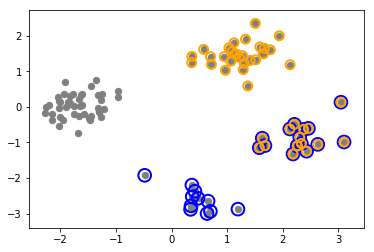

In [179]:
plot_result(result[0].T,Y)

In [16]:
result[1]

array([[ 10.56973716,   0.        ],
       [  0.        ,  12.06713116]])

# Lets try with the smart data

In [17]:
data = pd.read_excel('/home/hngu4068/Documents/SMART_STUDY/SMART_MasterDatabase_CCA.xlsx',sheetname = 1)

In [18]:
data.head()

,TreatmentGroup,ParticipantStudyID,Ageyears,EducationYrs,TICSMScore_BL,TotalDrinksperweek_BL,TotalInformantBayerIADLscore_BL,ParticipantSubjectiveMemoryConcernTotalScore_BL,MMSETrial1UncorrectedScore_BL,MMSETrial1CorrectedScore_BL,...,rh_rostralmiddlefrontal_thickness,rh_superiorfrontal_thickness,rh_superiorparietal_thickness,rh_superiortemporal_thickness,rh_supramarginal_thickness,rh_frontalpole_thickness,rh_temporalpole_thickness,rh_transversetemporal_thickness,rh_insula_thickness,rh_MeanThickness_thickness
0,Sham Exc+Sham cognitive,2,70.59,19,21,0.000,1.160,2,28,30,...,2.195,2.565,1.961,2.491,2.238,2.276,3.588,1.884,2.836,2.27532
1,Resistance training+ Sham cognitive,3,65.62,19,27,7.000,1.231,5,27,27,...,2.297,2.570,1.981,2.609,2.259,2.496,3.097,2.132,2.634,2.31103
2,Cognitive training+Sham exc,4,78.96,14,16,0.000,1.217,3,29,30,...,2.085,2.456,2.070,2.472,2.180,2.216,3.462,2.499,2.650,2.22049
3,Resistance training + Cognitive training,6,65.70,14,24,7.000,1.269,3,28,28,...,2.335,2.689,2.170,2.645,2.461,2.818,3.097,2.495,2.748,2.39028
4,Resistance training+ Sham cognitive,7,70.92,20,24,0.000,2.680,4,27,27,...,2.438,2.594,2.305,2.688,2.458,2.484,3.384,2.452,2.743,2.48118


In [19]:
BL_treatment_no =np.zeros((data.shape[0],1))
i = 0
for ele in data['TreatmentGroup'].unique():
    double_sham = data[data['TreatmentGroup'] == ele]
    double_sham_index = double_sham.index.values
    BL_treatment_no[double_sham_index] = i
    i+=1

In [20]:
cog_headings = data.columns.values
cog_headings = cog_headings[4:]
neuro_scores = data[cog_headings]
neuro_scores = neuro_scores.fillna(0)
neuro_scores= neuro_scores.replace('.', 0, regex=True)
neuro_scores['TotalDrinksperweek_BL'] = pd.to_numeric(neuro_scores['TotalDrinksperweek_BL'])

In [21]:
neuro_scores.head()

,TICSMScore_BL,TotalDrinksperweek_BL,TotalInformantBayerIADLscore_BL,ParticipantSubjectiveMemoryConcernTotalScore_BL,MMSETrial1UncorrectedScore_BL,MMSETrial1CorrectedScore_BL,CDRSum_BL,SUMofmemorytrials_BL,ADASCOGTotalScore_BL,TrailmakingtestPartAtotaltimesec_BL,...,rh_rostralmiddlefrontal_thickness,rh_superiorfrontal_thickness,rh_superiorparietal_thickness,rh_superiortemporal_thickness,rh_supramarginal_thickness,rh_frontalpole_thickness,rh_temporalpole_thickness,rh_transversetemporal_thickness,rh_insula_thickness,rh_MeanThickness_thickness
0,21,0,1.160,2,28,30,0.0,22,10.6,37,...,2.195,2.565,1.961,2.491,2.238,2.276,3.588,1.884,2.836,2.27532
1,27,0,1.231,5,27,27,1.0,22,10.9,27,...,2.297,2.570,1.981,2.609,2.259,2.496,3.097,2.132,2.634,2.31103
2,16,0,1.217,3,29,30,0.5,13,11.9,43,...,2.085,2.456,2.070,2.472,2.180,2.216,3.462,2.499,2.650,2.22049
3,24,0,1.269,3,28,28,0.5,27,4.3,27,...,2.335,2.689,2.170,2.645,2.461,2.818,3.097,2.495,2.748,2.39028
4,24,0,2.680,4,27,27,0.5,20,12.9,26,...,2.438,2.594,2.305,2.688,2.458,2.484,3.384,2.452,2.743,2.48118


In [22]:
from sklearn.preprocessing import minmax_scale
neuro_scores_scale = minmax_scale(neuro_scores)

In [23]:
BL_connectome = np.loadtxt('NET_BL.txt')

In [24]:
def reduce_connectome(connectome):
    n_subjects = connectome.shape[0]
    group_ICA_dim = int(np.sqrt(connectome.shape[1]))
    reduced_connectome = np.zeros((n_subjects,group_ICA_dim*(group_ICA_dim-1)/2))
    upper_tri_indices = np.triu_indices(group_ICA_dim,k=1)
    for i in range(n_subjects):
        subject = np.reshape(connectome[i,:],(group_ICA_dim,group_ICA_dim))
        reduced_connectome[i,:] = subject[upper_tri_indices]
    return reduced_connectome

In [25]:
#since row is a symmetric 49x49 matrix, we reshape each row to 49x49, then take the triangular upper elements
# (excluding the diagonal) and put it into a 1D array for each subject
#we therefore form a n_subject x 50*49/2 dimension array
n_subjects = BL_connectome.shape[0]
group_ICA_dim = int(np.sqrt(BL_connectome.shape[1]))
reduced_BL_connectome = np.zeros((n_subjects,group_ICA_dim*(group_ICA_dim-1)/2))
upper_tri_indices = np.triu_indices(group_ICA_dim,k=1)
for i in range(n_subjects):
    subject = np.reshape(BL_connectome[i,:],(group_ICA_dim,group_ICA_dim))
    reduced_BL_connectome[i,:] = subject[upper_tri_indices]

In [26]:
from sklearn.preprocessing import normalize
BL_connectome_normalize = normalize(reduced_BL_connectome)

In [27]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 20,whiten = True)
neuro_scores_scale_red = pca.fit_transform(neuro_scores_scale)
BL_connectome_normalize_red = pca.fit_transform(BL_connectome_normalize)

In [28]:
study_result = transform_to_z(neuro_scores_scale_red,BL_connectome_normalize_red)

Training CCA, regularization = 0.0000, 2 components


In [144]:
study_latent = study_result[0].T

In [142]:
BL_nontreatment_index, BL_treatment_index, BL_treatment_class = get_treatment_nontreatment_groups(data)
BL_treatment_study_latent = study_latent[BL_treatment_index,:]
BL_nontreatment_study_latent = study_latent[BL_nontreatment_index,:]

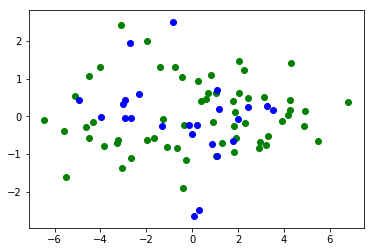

In [143]:
one = plt.scatter(BL_treatment_study_latent[:,0],BL_treatment_study_latent[:,1],color = 'green',label='Treatment')
two = plt.scatter(BL_nontreatment_study_latent[:,0],BL_nontreatment_study_latent[:,1],color = 'blue',label='Nontreatment')

In [30]:
treatment_class = pd.get_dummies(data['TreatmentGroup'])

In [31]:
def plot_study_result(X,Y):
    zero_class = np.where(Y[:, 0])
    one_class = np.where(Y[:, 1])
    two_class = np.where(Y[:, 2])
    three_class = np.where(Y[:, 3])
    
    plt.scatter(X[:, 0], X[:, 1], s=40, c='gray')
    one= plt.scatter(X[zero_class, 0], X[zero_class, 1], s=160, edgecolors='b',
                   facecolors='none', linewidths=2, label='Class C+R_Sham')
    two = plt.scatter(X[one_class, 0], X[one_class, 1], s=80, edgecolors='orange',
                   facecolors='none', linewidths=2, label='Class R+C')
    three =plt.scatter(X[two_class, 0], X[two_class, 1], s=160, edgecolors='red',
                   facecolors='none', linewidths=2, label='Class R+C_Sham')
    four = plt.scatter(X[three_class, 0], X[three_class, 1], s=80, edgecolors='green',
                   facecolors='none', linewidths=2, label='Class Double Shammy')
    plt.legend(handles=[one,two,three,four])

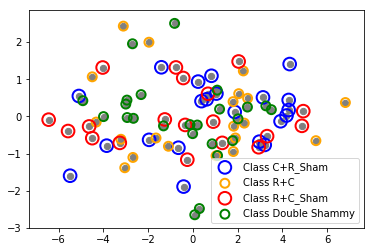

In [32]:
plot_study_result(study_latent,treatment_class.values)

In [33]:
## calculate the mean and variance of the transform variable
BL_mu = np.mean(study_latent,axis = 0)
print "BL mean is %s" %np.array_str(BL_mu)
BL_sigma = np.cov(study_latent.T)
print "BL variance is %s" %np.array_str(BL_sigma)

BL mean is [  1.42742960e-16  -2.51121875e-17]
BL variance is [[  8.96686413e+00   1.11062656e-16]
 [  1.11062656e-16   9.07711108e-01]]


## lets go deeper with the CCA analysis

In [34]:
BL_cca = rcca.CCA(kernelcca = False,reg =100, numCC = 1)
BL_cca.train([neuro_scores_scale_red,BL_connectome_normalize_red])

Training CCA, regularization = 100.0000, 1 components


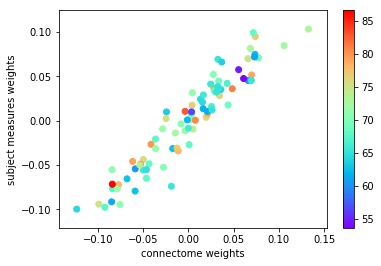

In [35]:
temp = plt.scatter(BL_cca.comps[0],BL_cca.comps[1],c = data['Ageyears'],cmap='rainbow')
plt.xlabel('connectome weights')
plt.ylabel('subject measures weights')
plt.colorbar(temp)

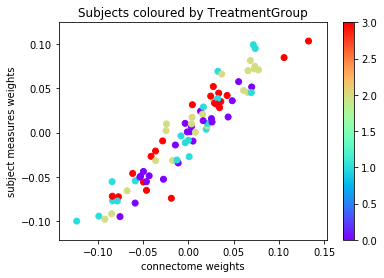

In [36]:
temp = plt.scatter(BL_cca.comps[0],BL_cca.comps[1],c = BL_treatment_no,cmap='rainbow')
plt.xlabel('connectome weights')
plt.ylabel('subject measures weights')
plt.title('Subjects coloured by TreatmentGroup')
plt.colorbar(temp)

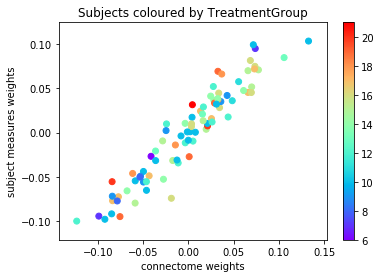

In [37]:
temp = plt.scatter(BL_cca.comps[0],BL_cca.comps[1],c = data['EducationYrs'],cmap='rainbow')
plt.xlabel('connectome weights')
plt.ylabel('subject measures weights')
plt.title('Subjects coloured by TreatmentGroup')
plt.colorbar(temp)

# Lets look at FU1

In [4]:
FU1_data = pd.read_excel('/home/hngu4068/Documents/SMART_STUDY/SMART_MasterDatabase_CCA.xlsx',sheetname = 2)

In [5]:
FU1_data.head()

,TreatmentGroup,ParticipantStudyID,Ageyears,EducationYrs,TotalInformantBayerIADLscore_612,ParticipantSubjectiveMemoryConcernTotalScore_612,CDRSum_612,SUMofmemorytrials_612,ADASCOGTotalScore_612,MMSEUncorrectedScore_612,...,rh_rostralmiddlefrontal_thickness,rh_superiorfrontal_thickness,rh_superiorparietal_thickness,rh_superiortemporal_thickness,rh_supramarginal_thickness,rh_frontalpole_thickness,rh_temporalpole_thickness,rh_transversetemporal_thickness,rh_insula_thickness,rh_MeanThickness_thickness
0,Sham Exc+Sham cognitive,2,70.59,19,1.115,.,2.0,17.0,12.0,.,...,2.197,2.599,1.944,2.459,2.219,2.262,3.581,1.883,2.790,2.27350
1,Resistance training+ Sham cognitive,3,65.62,19,1.153,.,0.5,23.0,6.6,.,...,2.341,2.607,2.002,2.680,2.302,2.655,3.291,2.285,2.738,2.36391
2,Cognitive training+Sham exc,4,78.96,14,1.000,.,4.5,15.0,15.3,.,...,2.357,2.546,2.008,2.671,2.374,2.507,3.827,2.376,2.887,2.37256
3,Resistance training + Cognitive training,6,65.70,14,1.346,.,0.0,24.0,6.0,.,...,2.205,2.503,2.193,2.642,2.519,2.320,3.375,2.449,2.868,2.33653
4,Resistance training+ Sham cognitive,7,70.92,20,3.615,.,0.0,24.0,6.6,.,...,2.250,2.765,2.202,2.619,2.484,2.509,3.248,2.189,2.680,2.42852


In [6]:
nontreatment_group = FU1_data[FU1_data['TreatmentGroup'] == 'Sham Exc+Sham cognitive']
nontreatment_group_index = nontreatment_group.index.values

treatment_group = FU1_data[FU1_data['TreatmentGroup'] != 'Sham Exc+Sham cognitive']
treatment_group_index = treatment_group.index.values

FU1_treatment_class = pd.get_dummies(FU1_data['TreatmentGroup'])

In [7]:
FU1_cog_headings = FU1_data.columns.values
FU1_cog_headings = FU1_cog_headings[4:]
FU1_neuro_scores = FU1_data[FU1_cog_headings]
FU1_neuro_scores = FU1_neuro_scores.fillna(0)
FU1_neuro_scores= FU1_neuro_scores.replace('.', 0, regex=True)

In [8]:
FU1_neuro_scores.head()

,TotalInformantBayerIADLscore_612,ParticipantSubjectiveMemoryConcernTotalScore_612,CDRSum_612,SUMofmemorytrials_612,ADASCOGTotalScore_612,MMSEUncorrectedScore_612,TrailmakingtestPartAtotaltimesec_612,TrailmakingtestPartBtotaltimesec_612,WAISMatricesTotalScore_612,WAISSimilaritiesTotalScore_612,...,rh_rostralmiddlefrontal_thickness,rh_superiorfrontal_thickness,rh_superiorparietal_thickness,rh_superiortemporal_thickness,rh_supramarginal_thickness,rh_frontalpole_thickness,rh_temporalpole_thickness,rh_transversetemporal_thickness,rh_insula_thickness,rh_MeanThickness_thickness
0,1.115,0,2.0,17.0,12.0,0,39,0,7,16,...,2.197,2.599,1.944,2.459,2.219,2.262,3.581,1.883,2.790,2.27350
1,1.153,0,0.5,23.0,6.6,0,37,0,19,30,...,2.341,2.607,2.002,2.680,2.302,2.655,3.291,2.285,2.738,2.36391
2,1.000,0,4.5,15.0,15.3,0,48,0,5,11,...,2.357,2.546,2.008,2.671,2.374,2.507,3.827,2.376,2.887,2.37256
3,1.346,0,0.0,24.0,6.0,0,33,0,22,24,...,2.205,2.503,2.193,2.642,2.519,2.320,3.375,2.449,2.868,2.33653
4,3.615,0,0.0,24.0,6.6,0,39,0,17,25,...,2.250,2.765,2.202,2.619,2.484,2.509,3.248,2.189,2.680,2.42852


In [11]:
FU1_neuro_scores_scale = minmax_scale(FU1_neuro_scores)
pca = PCA(n_components = 15)
FU1_neuro_scores_scale_red = pca.fit_transform(FU1_neuro_scores_scale)

NameError: name 'minmax_scale' is not defined

In [98]:
FU1_treatment_group_neuro_scale = FU1_neuro_scores_scale_red[treatment_group_index,:]
FU1_nontreatment_group_neuro_scale = FU1_neuro_scores_scale_red[nontreatment_group_index,:]

In [99]:
FU1_connectome = np.loadtxt('NET_FU1.txt')
FU1_connectome_reduced = reduce_connectome(FU1_connectome)
FU1_connectome_normalize = normalize(FU1_connectome_reduced)
FU1_connectome_normalize_red = pca.fit_transform(FU1_connectome_normalize)

FU1_connectome_treatment = FU1_connectome_normalize_red[treatment_group_index,:]
FU1_connectome_nontreatment = FU1_connectome_normalize_red[nontreatment_group_index,:]

In [100]:
FU1_study_result_treatment = transform_to_z(FU1_treatment_group_neuro_scale,FU1_connectome_treatment,reg=10)

Training CCA, regularization = 0.0000, 2 components


In [102]:
FU1_study_result_nontreatment = transform_to_z(FU1_nontreatment_group_neuro_scale,FU1_connectome_nontreatment,reg=10)

Training CCA, regularization = 10.0000, 2 components


In [103]:
FU1_treatment_study_latent = FU1_study_result_treatment[0].T
FU1_nontreatment_study_latent = FU1_study_result_nontreatment[0].T

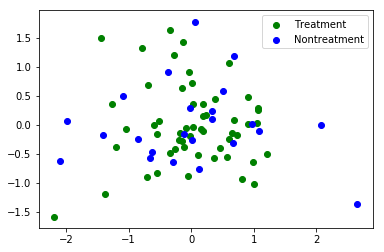

In [105]:
one = plt.scatter(FU1_treatment_study_latent[:,0],FU1_treatment_study_latent[:,1],color = 'green',label='Treatment')
two = plt.scatter(FU1_nontreatment_study_latent[:,0],FU1_nontreatment_study_latent[:,1],color = 'blue',label='Nontreatment')
plt.legend(handles=[one,two])

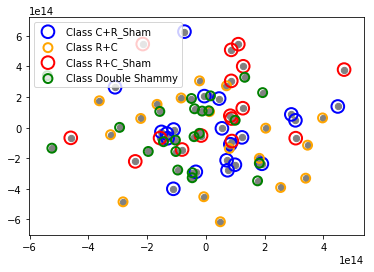

In [166]:
#do analysis all together
FU1_study_result = transform_to_z(FU1_neuro_scores_scale,FU1_connectome_normalize,reg=10)
plot_study_result(FU1_study_result[0].T,FU1_treatment_class.values)

In [108]:
FU1_study_latent = np.zeros((77,2))
FU1_study_latent[treatment_group_index,:] = FU1_treatment_study_latent
FU1_study_latent[nontreatment_group_index,:] = FU1_nontreatment_study_latent

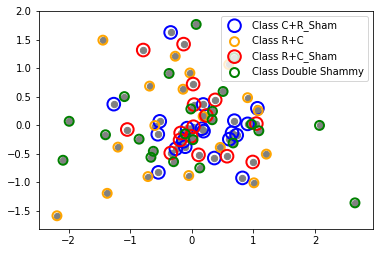

In [109]:
plot_study_result(FU1_study_latent,FU1_treatment_class.values)

In [110]:
FU1_treatment_mu = np.mean(FU1_treatment_study_latent,axis = 0)
print "FU1 treatment mean is %s" %np.array_str(FU1_treatment_mu)
FU1_treatment_sigma = np.cov(FU1_treatment_study_latent.T)
print "FU1 treatment variance is %s" %np.array_str(FU1_treatment_sigma)

FU1 treatment mean is [  2.67275913e-17  -2.36436385e-17]
FU1 treatment variance is [[ 0.54022091 -0.00222994]
 [-0.00222994  0.47984115]]


In [111]:
FU1_nontreatment_mu = np.mean(FU1_nontreatment_study_latent,axis = 0)
print "FU1 nontreatment mean is %s" %np.array_str(FU1_nontreatment_mu)
FU1_nontreatment_sigma = np.cov(FU1_nontreatment_study_latent.T)
print "FU1 nontreatment variance is %s" %np.array_str(FU1_nontreatment_sigma)

FU1 nontreatment mean is [  1.93082265e-17   4.82705663e-17]
FU1 nontreatment variance is [[ 1.28086286 -0.04957049]
 [-0.04957049  0.46070041]]


## Lets do a whole group analysis

In [112]:
FU1_cca = rcca.CCA(kernelcca = False,reg =1, numCC = 1)
FU1_cca.train([FU1_neuro_scores_scale_red,FU1_connectome_normalize_red])

Training CCA, regularization = 1.0000, 1 components


In [113]:
FU1_treatment_no =np.zeros((FU1_data.shape[0],1))
i = 0
for ele in FU1_data['TreatmentGroup'].unique():
    double_sham = FU1_data[FU1_data['TreatmentGroup'] == ele]
    double_sham_index = double_sham.index.values
    FU1_treatment_no[double_sham_index] = i
    i+=1

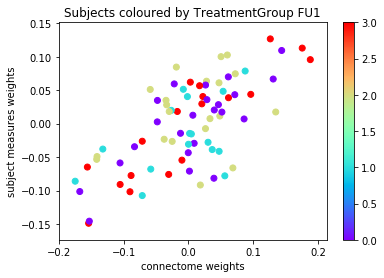

In [114]:
temp = plt.scatter(FU1_cca.comps[0],FU1_cca.comps[1],c = FU1_treatment_no,cmap = 'rainbow')
plt.xlabel('connectome weights')
plt.ylabel('subject measures weights')
plt.title('Subjects coloured by TreatmentGroup FU1')
plt.colorbar(temp)

There's quite a difference between the distribution of the groups nontreatment variance is quite different from treatment

# FU2

In [115]:
FU2_data = pd.read_excel('/home/hngu4068/Documents/SMART_STUDY/SMART_MasterDatabase_CCA.xlsx',sheetname = 3)
FU2_data.head()

,TreatmentGroup,ParticipantStudyID,Ageyears,EducationYrs,TotalInformantBayerIADLscore_1812,ParticipantSubjectiveMemoryConcernTotalScore_1812,CDRSum_1812,SUMofmemorytrials_1812,ADASCOGTotalScore_1812,MMSEUncorrectedScore_1812,...,rh_rostralmiddlefrontal_thickness,rh_superiorfrontal_thickness,rh_superiorparietal_thickness,rh_superiortemporal_thickness,rh_supramarginal_thickness,rh_frontalpole_thickness,rh_temporalpole_thickness,rh_transversetemporal_thickness,rh_insula_thickness,rh_MeanThickness_thickness
0,Sham Exc+Sham cognitive,2,70.59,19,1.125,0.0,0.0,22.0,3.6,.,...,2.157,2.555,1.939,2.482,2.189,2.298,3.659,1.821,2.780,2.24567
1,Resistance training+ Sham cognitive,3,65.62,19,1.115,2.0,0.0,26.0,4.9,.,...,2.296,2.581,1.998,2.626,2.282,2.541,3.216,2.176,2.720,2.33162
2,Cognitive training+Sham exc,4,78.96,14,1.291,3.0,2.5,16.0,9.6,24,...,1.957,2.324,1.812,2.475,1.998,1.993,3.584,2.401,2.695,2.10551
3,Resistance training + Cognitive training,6,65.70,14,1.269,2.0,0.0,27.0,4.0,30,...,2.269,2.665,2.150,2.669,2.425,2.863,3.089,2.642,2.731,2.35755
4,Resistance training+ Sham cognitive,7,70.92,20,1.692,2.0,1.0,24.0,5.6,28,...,2.261,2.477,2.043,2.587,2.176,2.265,3.278,2.139,2.646,2.29072


In [116]:
def get_treatment_nontreatment_groups(data):
    nontreatment = data[data['TreatmentGroup'] == 'Sham Exc+Sham cognitive']
    nontreatment_index = nontreatment.index.values
    
    treatment = data[data['TreatmentGroup'] != 'Sham Exc+Sham cognitive']
    treatment_index = treatment.index.values
    
    treatment_class = pd.get_dummies(data['TreatmentGroup'])
    
    return nontreatment_index, treatment_index, treatment_class

In [117]:
FU2_nontreatment_index, FU2_treatment_index, FU2_treatment_class = get_treatment_nontreatment_groups(FU2_data)

In [118]:
def get_neuro_scores(data):
    cog_headings = data.columns.values
    cog_headings = cog_headings[4:]
    neuro_scores = data[cog_headings]
    neuro_scores = neuro_scores.fillna(0)
    return neuro_scores

In [119]:
FU2_neuro_scores = get_neuro_scores(FU2_data)
FU2_neuro_scores.head()

,TotalInformantBayerIADLscore_1812,ParticipantSubjectiveMemoryConcernTotalScore_1812,CDRSum_1812,SUMofmemorytrials_1812,ADASCOGTotalScore_1812,MMSEUncorrectedScore_1812,TrailmakingtestPartAtotaltimesec_1812,TrailmakingtestPartBtotaltimesec_1812,WAISMatricesTotalScore_1812,WAISSimilaritiesTotalScore_1812,...,rh_rostralmiddlefrontal_thickness,rh_superiorfrontal_thickness,rh_superiorparietal_thickness,rh_superiortemporal_thickness,rh_supramarginal_thickness,rh_frontalpole_thickness,rh_temporalpole_thickness,rh_transversetemporal_thickness,rh_insula_thickness,rh_MeanThickness_thickness
0,1.125,0.0,0.0,22.0,3.6,0,31,79,9,28,...,2.157,2.555,1.939,2.482,2.189,2.298,3.659,1.821,2.780,2.24567
1,1.115,2.0,0.0,26.0,4.9,0,29,58,20,24,...,2.296,2.581,1.998,2.626,2.282,2.541,3.216,2.176,2.720,2.33162
2,1.291,3.0,2.5,16.0,9.6,0,47,246,5,10,...,1.957,2.324,1.812,2.475,1.998,1.993,3.584,2.401,2.695,2.10551
3,1.269,2.0,0.0,27.0,4.0,0,39,79,21,21,...,2.269,2.665,2.150,2.669,2.425,2.863,3.089,2.642,2.731,2.35755
4,1.692,2.0,1.0,24.0,5.6,0,28,62,11,23,...,2.261,2.477,2.043,2.587,2.176,2.265,3.278,2.139,2.646,2.29072


In [120]:
FU2_neuro_scores_scale = minmax_scale(FU2_neuro_scores)
pca = PCA(n_components = 30)
FU2_neuro_scores_scale_red = pca.fit_transform(FU2_neuro_scores_scale)

FU2_treatment_neuro_scale = FU2_neuro_scores_scale_red[FU2_treatment_index,:]
FU2_nontreatment_neuro_scale = FU2_neuro_scores_scale_red[FU2_nontreatment_index,:]

In [121]:
FU2_connectome = np.loadtxt('NET_FU2.txt')
FU2_connectome = np.concatenate((FU2_connectome[1:35,:],FU2_connectome[36:,:]))
FU2_connectome_reduced = reduce_connectome(FU2_connectome)
FU2_connectome_normalize = normalize(FU2_connectome_reduced)
FU2_connectome_normalize_red = pca.fit_transform(FU2_connectome_normalize)

FU2_connectome_treatment = FU2_connectome_normalize_red[FU2_treatment_index,:]
FU2_connectome_nontreatment = FU2_connectome_normalize_red[FU2_nontreatment_index,:]

In [122]:
FU2_study_result_treatment = transform_to_z(FU2_treatment_neuro_scale,FU2_connectome_treatment,n_components = 2, reg = 1)

Training CCA, regularization = 1.0000, 2 components


In [123]:
FU2_study_result_nontreatment = transform_to_z(FU2_nontreatment_neuro_scale,FU2_connectome_nontreatment,n_components = 2, reg = 1)

Training CCA, regularization = 1.0000, 2 components


In [124]:
FU2_treatment_study_latent = FU2_study_result_treatment[0].T
FU2_nontreatment_study_latent = FU2_study_result_nontreatment[0].T

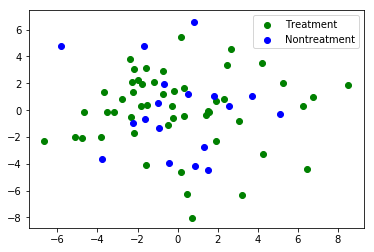

In [125]:
one = plt.scatter(FU2_treatment_study_latent[:,0],FU2_treatment_study_latent[:,1],color = 'green',label='Treatment')
two = plt.scatter(FU2_nontreatment_study_latent[:,0]/5,FU2_nontreatment_study_latent[:,1]/5,color = 'blue',label='Nontreatment')
plt.legend(handles=[one,two])

In [126]:
FU2_study_latent = np.zeros((77,2))
FU2_study_latent[FU2_treatment_index,:] = FU2_treatment_study_latent
FU2_study_latent[FU2_nontreatment_index,:] = FU2_nontreatment_study_latent/5

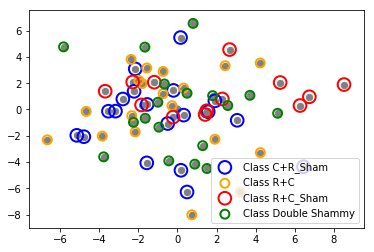

In [127]:
plot_study_result(FU2_study_latent,FU2_treatment_class.values)

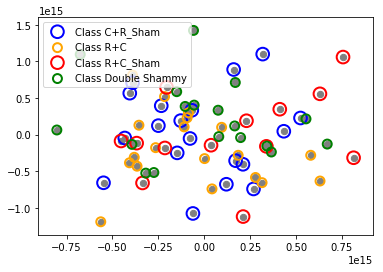

In [167]:
#do analysis altogether
FU2_study_result = transform_to_z(FU2_neuro_scores_scale,FU2_connectome_normalize,reg=1)
plot_study_result(FU2_study_result[0].T,FU2_treatment_class.values)

In [128]:
FU2_treatment_mu = np.mean(FU2_treatment_study_latent,axis = 0)
print "FU2 treatment mean is %s" %np.array_str(FU2_treatment_mu)
FU2_treatment_sigma = np.cov(FU2_treatment_study_latent.T)
print "FU2 treatment variance is %s" %np.array_str(FU2_treatment_sigma)

FU2 treatment mean is [  2.61228947e-17   2.82998026e-17]
FU2 treatment variance is [[ 10.8185706    0.01500607]
 [  0.01500607   7.905189  ]]


In [129]:
FU2_nontreatment_mu = np.mean(FU2_nontreatment_study_latent,axis = 0)
print "FU2 nontreatment mean is %s" %np.array_str(FU2_nontreatment_mu)
FU2_nontreatment_sigma = np.cov(FU2_nontreatment_study_latent.T)
print "FU2 nontreatment variance is %s" %np.array_str(FU2_nontreatment_sigma)

FU2 nontreatment mean is [ -2.71387850e-16   1.18423789e-15]
FU2 nontreatment variance is [[ 171.59139548  -30.31087876]
 [ -30.31087876  254.44284596]]


### Lets do a whole group analysis

In [130]:
FU2_cca = rcca.CCA(kernelcca = False,reg =10, numCC = 1)
FU2_cca.train([FU2_neuro_scores_scale_red,FU2_connectome_normalize_red])

Training CCA, regularization = 10.0000, 1 components


In [131]:
FU2_treatment_no =np.zeros((FU2_data.shape[0],1))
i = 0
for ele in FU2_data['TreatmentGroup'].unique():
    double_sham = FU2_data[FU2_data['TreatmentGroup'] == ele]
    double_sham_index = double_sham.index.values
    FU2_treatment_no[double_sham_index] = i
    i+=1

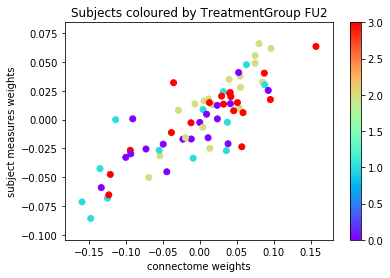

In [132]:
temp = plt.scatter(FU2_cca.comps[0],FU2_cca.comps[1],c = FU2_treatment_no,cmap = 'rainbow')
plt.xlabel('connectome weights')
plt.ylabel('subject measures weights')
plt.title('Subjects coloured by TreatmentGroup FU2')
plt.colorbar(temp)

### Lets plot all the things together for treatment group

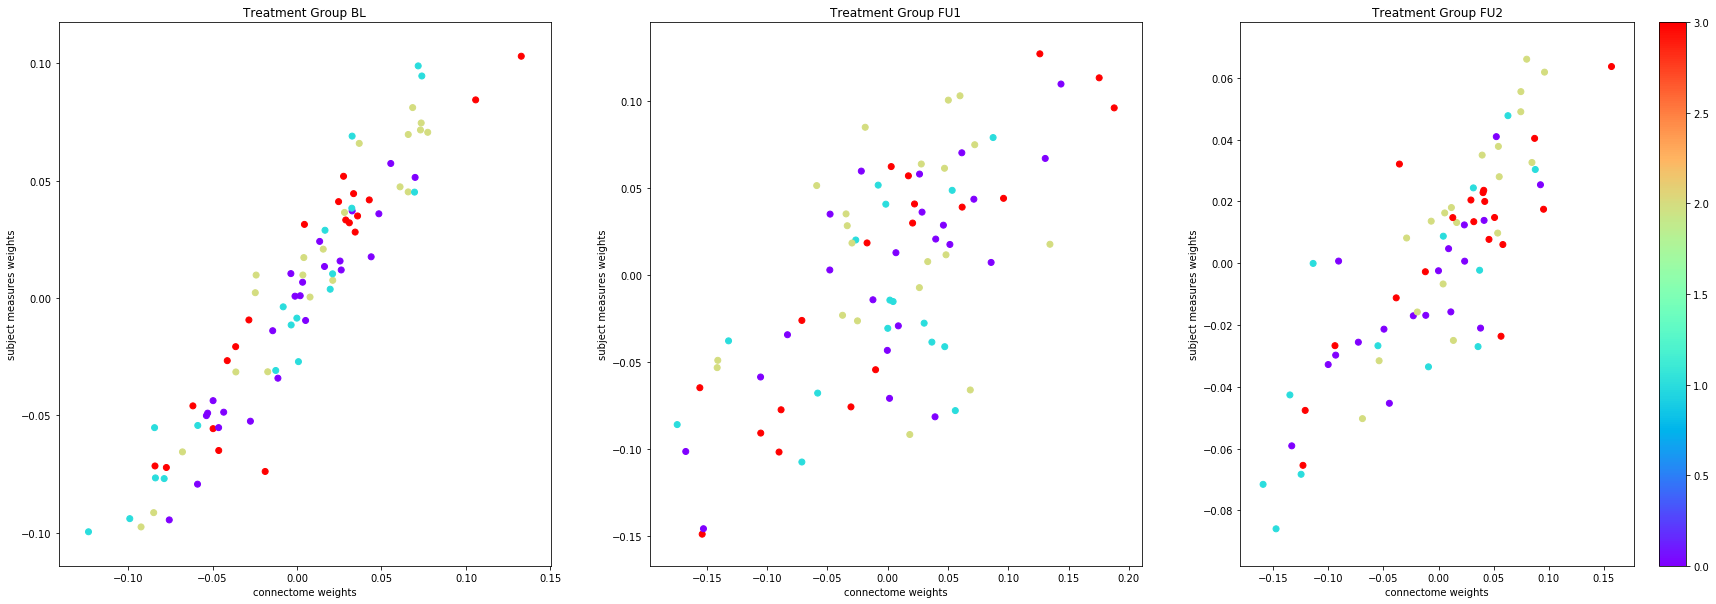

In [133]:
plt.figure(figsize=(30, 10))
plt.subplot(1,3,1)
temp = plt.scatter(BL_cca.comps[0],BL_cca.comps[1],c = BL_treatment_no,cmap='rainbow')
plt.xlabel('connectome weights')
plt.ylabel('subject measures weights')
plt.title('Treatment Group BL')
#plt.colorbar(temp)
plt.subplot(1,3,2)
temp = plt.scatter(FU1_cca.comps[0],FU1_cca.comps[1],c = FU1_treatment_no,cmap = 'rainbow')0
plt.xlabel('connectome weights')
plt.ylabel('subject measures weights')
plt.title('Treatment Group FU1')
#plt.colorbar(temp)
plt.subplot(1,3,3)
temp = plt.scatter(FU2_cca.comps[0],FU2_cca.comps[1],c = FU2_treatment_no,cmap = 'rainbow')
plt.xlabel('connectome weights')
plt.ylabel('subject measures weights')
plt.title('Treatment Group FU2')
plt.colorbar(temp)

### Do the same for age

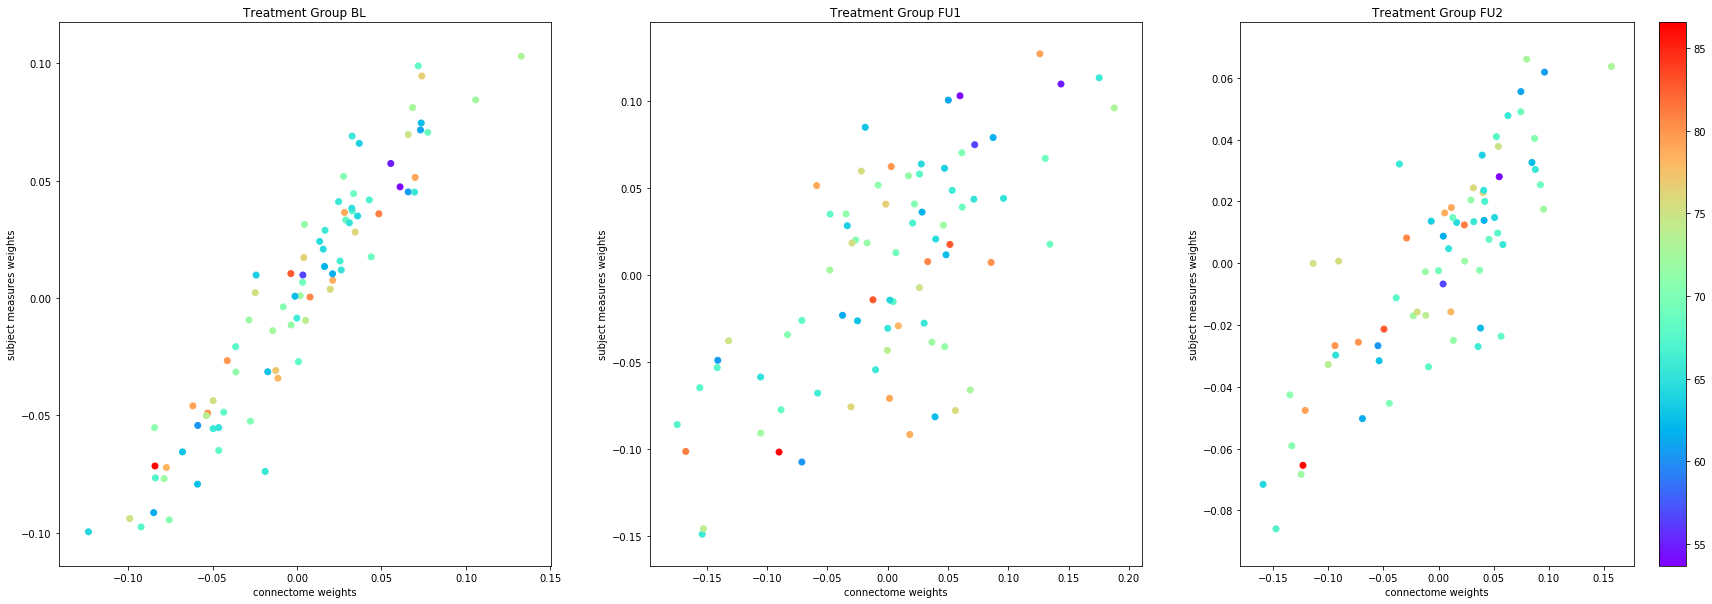

In [134]:
plt.figure(figsize=(30, 10))
plt.subplot(1,3,1)
temp = plt.scatter(BL_cca.comps[0],BL_cca.comps[1],c = data['Ageyears'],cmap='rainbow')
plt.xlabel('connectome weights')
plt.ylabel('subject measures weights')
plt.title('Treatment Group BL')
#plt.colorbar(temp)
plt.subplot(1,3,2)
temp = plt.scatter(FU1_cca.comps[0],FU1_cca.comps[1],c = FU1_data['Ageyears'],cmap = 'rainbow')
plt.xlabel('connectome weights')
plt.ylabel('subject measures weights')
plt.title('Treatment Group FU1')
#plt.colorbar(temp)
plt.subplot(1,3,3)
temp = plt.scatter(FU2_cca.comps[0],FU2_cca.comps[1],c = FU2_data['Ageyears'],cmap = 'rainbow')
plt.xlabel('connectome weights')
plt.ylabel('subject measures weights')
plt.title('Treatment Group FU2')
plt.colorbar(temp)

### same for education

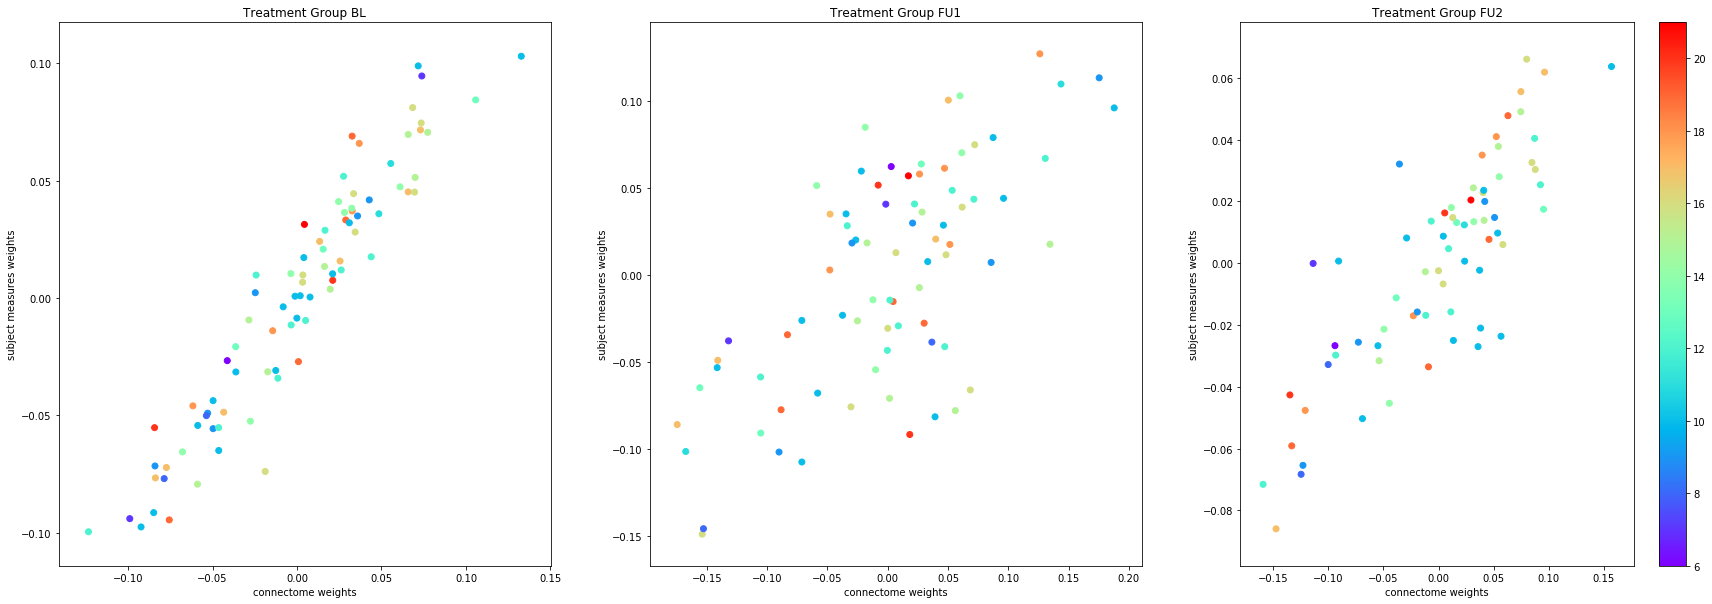

In [136]:
plt.figure(figsize=(30, 10))
plt.subplot(1,3,1)
temp = plt.scatter(BL_cca.comps[0],BL_cca.comps[1],c = data['EducationYrs'],cmap='rainbow')
plt.xlabel('connectome weights')
plt.ylabel('subject measures weights')
plt.title('Treatment Group BL')
#plt.colorbar(temp)
plt.subplot(1,3,2)
temp = plt.scatter(FU1_cca.comps[0],FU1_cca.comps[1],c = FU1_data['EducationYrs'],cmap = 'rainbow')
plt.xlabel('connectome weights')
plt.ylabel('subject measures weights')
plt.title('Treatment Group FU1')
#plt.colorbar(temp)
plt.subplot(1,3,3)
temp = plt.scatter(FU2_cca.comps[0],FU2_cca.comps[1],c = FU2_data['EducationYrs'],cmap = 'rainbow')
plt.xlabel('connectome weights')
plt.ylabel('subject measures weights')
plt.title('Treatment Group FU2')
plt.colorbar(temp)

## Plot the transformed variables

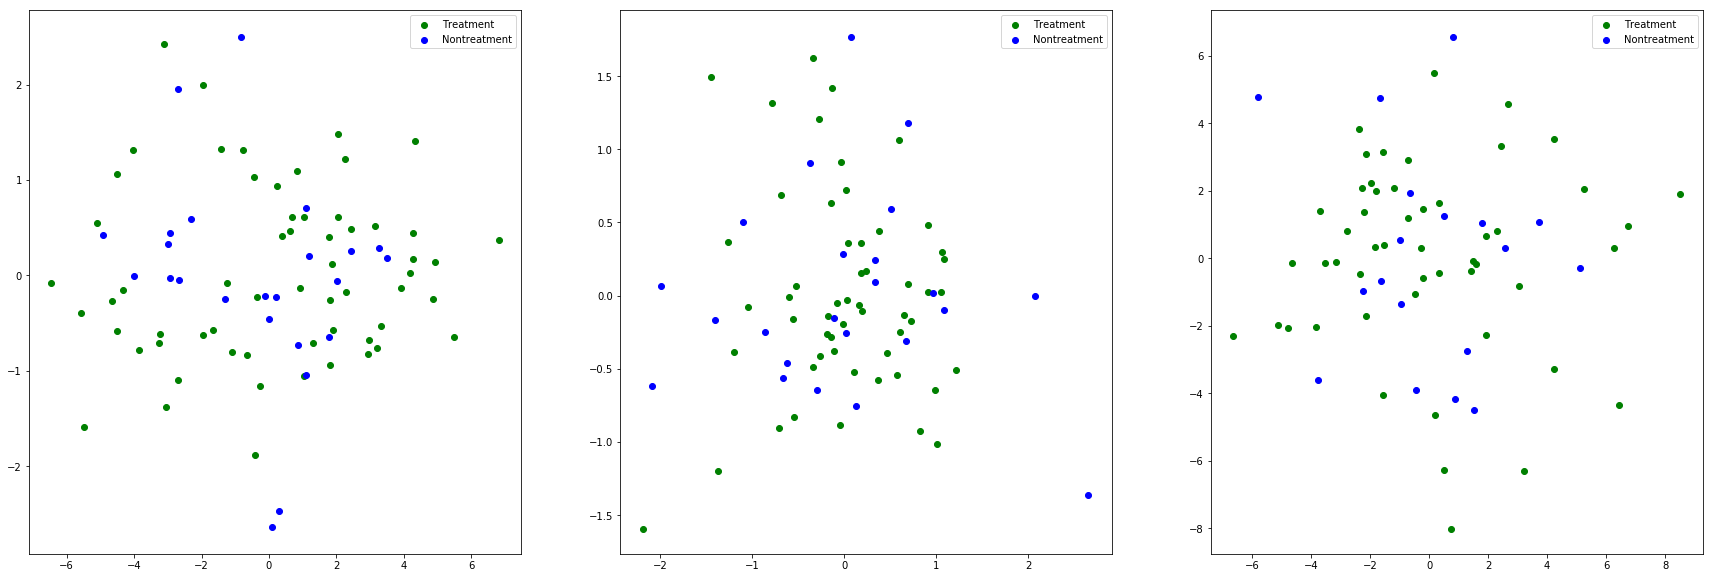

In [145]:
plt.figure(figsize=((30,10)))
plt.subplot(1,3,1)
one = plt.scatter(BL_treatment_study_latent[:,0],BL_treatment_study_latent[:,1],color = 'green',label='Treatment')
two = plt.scatter(BL_nontreatment_study_latent[:,0],BL_nontreatment_study_latent[:,1],color = 'blue',label='Nontreatment')
plt.legend(handles=[one,two])
plt.subplot(1,3,2)
one = plt.scatter(FU1_treatment_study_latent[:,0],FU1_treatment_study_latent[:,1],color = 'green',label='Treatment')
two = plt.scatter(FU1_nontreatment_study_latent[:,0],FU1_nontreatment_study_latent[:,1],color = 'blue',label='Nontreatment')
plt.legend(handles=[one,two])
plt.subplot(1,3,3)
one = plt.scatter(FU2_treatment_study_latent[:,0],FU2_treatment_study_latent[:,1],color = 'green',label='Treatment')
two = plt.scatter(FU2_nontreatment_study_latent[:,0]/5,FU2_nontreatment_study_latent[:,1]/5,color = 'blue',label='Nontreatment')
plt.legend(handles=[one,two])

# Lets do the qr cca

In [171]:
result = prob_CCA(neuro_scores_scale,BL_connectome_normalize,2)

In [172]:
result[0].shape

(247, 2)

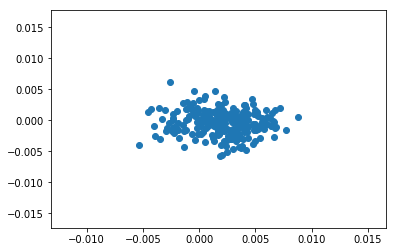

In [174]:
plt.scatter(result[0][:,0],result[0][:,1])

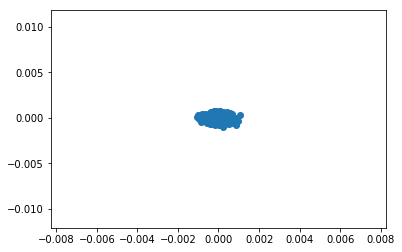

In [176]:
plt.scatter(result[1][:,0],result[1][:,1])

In [162]:
result[1].shape

(1176, 2)